***Setting up Project and Bucket***

In [1]:
PROJECT=!gcloud config get-value project
PROJECT=PROJECT[0]
BUCKET = PROJECT + '-dsongcp'
import os
os.environ['BUCKET'] = PROJECT + '-dsongcp'

***Start Pyspark session***

from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext('local', 'logistic')
spark = SparkSession \
    .builder \
    .appName("Logistic regression w/ Spark ML") \
    .getOrCreate()

***Create a Spark Dataframe for training***

In [3]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

***Read the dataset***

In [4]:
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))
traindays.createOrReplaceTempView('traindays')

In [5]:
traindays.createOrReplaceTempView('traindays')

In [6]:
spark.sql("SELECT * from traindays LIMIT 5").show()

+----------+------------+
|   FL_DATE|is_train_day|
+----------+------------+
|2015-01-01|        True|
|2015-01-02|       False|
|2015-01-03|       False|
|2015-01-04|        True|
|2015-01-05|        True|
+----------+------------+



In [7]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET)

In [8]:
flights = spark.read.json(inputs)
flights.createOrReplaceTempView('flights')

In [9]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True'
"""
traindata = spark.sql(trainquery)

In [10]:
print(traindata.head(2))

[Row(DEP_DELAY=-3.0, TAXI_OUT=14.0, ARR_DELAY=-16.0, DISTANCE='370.00'), Row(DEP_DELAY=24.0, TAXI_OUT=12.0, ARR_DELAY=12.0, DISTANCE='370.00')]


In [11]:
traindata.describe().show()

25/01/28 16:34:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46439|             46422|             46355|            46936|
|   mean| 8.561769202609876|15.427685149282668|3.2853413871211306|916.0707133117437|
| stddev|30.752752455053308| 8.427384168645757| 32.98848343691196|591.9164453757172|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



***Clean the dataset***

In [12]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.dep_delay IS NOT NULL AND 
  f.arr_delay IS NOT NULL
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46355|             46355|             46355|            46355|
|   mean| 8.539531873584295|15.421507927947363|3.2853413871211306| 917.660230827311|
| stddev|30.700034730525516|  8.41130660980497| 32.98848343691196|592.0960248192869|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



***Remove flights that have been cancelled or diverted using the following query:***

In [13]:
trainquery = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.CANCELLED == 'False' AND 
  f.DIVERTED == 'False'
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             46355|             46355|             46355|            46355|
|   mean| 8.539531873584295|15.421507927947363|3.2853413871211306| 917.660230827311|
| stddev|30.700034730525516|  8.41130660980497| 32.98848343691196|592.0960248192869|
|    min|             -22.0|               2.0|             -77.0|          1009.00|
|    max|             711.0|             178.0|             719.0|           980.00|
+-------+------------------+------------------+------------------+-----------------+



***Develop a logistic regression model***

In [14]:
def to_example(fields):
    return LabeledPoint(\
              float(fields['ARR_DELAY'] < 15), #ontime? \
              [ \
                  fields['DEP_DELAY'], \
                  fields['TAXI_OUT'],  \
                  fields['DISTANCE'],  \
              ])

In [43]:
## Mapping
examples = traindata.rdd.map(to_example)

The training DataFrame creates a logistic regression model based on your training dataset.

Use the intercept=True parameter because the prediction for arrival delay does not equal zero when all of the inputs are zero in this case.
If you have a training dataset where you expect that a prediction should be zero when the inputs are all zero, then you would specify intercept=False.

In [16]:
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)

In [17]:
print(lrmodel.weights,lrmodel.intercept)

[-0.1792651681210795,-0.13534106769473025,0.00047781028703737977] 5.403405716911976


In [18]:
print(lrmodel.predict([6.0,12.0,594.0]))

1


In [19]:
print(lrmodel.predict([36.0,12.0,594.0]))

0


In [20]:
lrmodel.clearThreshold()
print(lrmodel.predict([6.0,12.0,594.0]))
print(lrmodel.predict([36.0,12.0,594.0]))

0.9520080958815501
0.08390661628038797


In [24]:
lrmodel.setThreshold(0.7)
print(lrmodel.predict([6.0,12.0,594.0]))
print(lrmodel.predict([36.0,12.0,594.0]))

1
0


***Save and restore a logistic regression model***

In [25]:
MODEL_FILE = "gs://"+BUCKET+'/flights/sparkmloutput/model'
os.system('gsutil -m rm -r ' + MODEL_FILE)

CommandException: 1 files/objects could not be removed.


256

This should report an error stating CommandException: 1 files/objects could not be removed because the model has not been saved yet. The error indicates that there are no files present in the target location. You must be certain that this location is empty before attempting to save the model and this command guarantees that.
Save the model by running below

In [26]:
lrmodel.save(sc, MODEL_FILE)
print("saved : {}".format(MODEL_FILE))

saved : gs://qwiklabs-gcp-00-b2b1435cd374-dsongcp/flights/sparkmloutput/model


In [44]:
# destroy the model
lrmodel = 0
print(lrmodel)

0


***Retrieve the model***

In [29]:
from pyspark.mllib.classification import LogisticRegressionModel

lrmodel = LogisticRegressionModel.load(sc, MODEL_FILE)
lrmodel.setThreshold(0.7)

***Predict with the logistic regression model***

In [30]:
print(lrmodel.predict([36.0,12.0,594.0]))

0


In [31]:
print(lrmodel.predict([8.0,4.0,594.0]))

1


In [32]:
lrmodel.clearThreshold()
print(lrmodel.predict([20, 10, 500]))

0.6689847507160201


Text(0, 0.5, 'probability of ontime arrival')

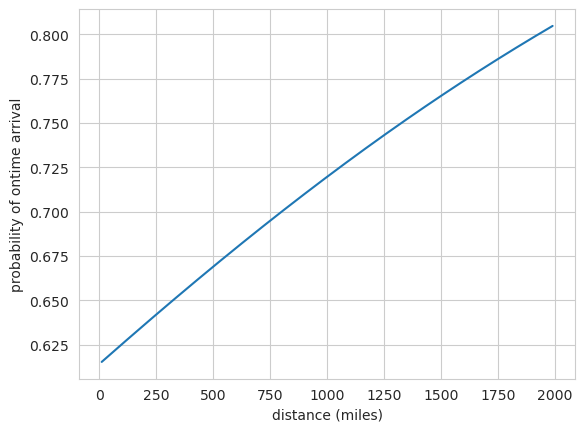

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]
sns.set_style("whitegrid")
ax = plt.plot(dist, prob)
plt.xlabel('distance (miles)')
plt.ylabel('probability of ontime arrival')

Text(0, 0.5, 'probability of ontime arrival')

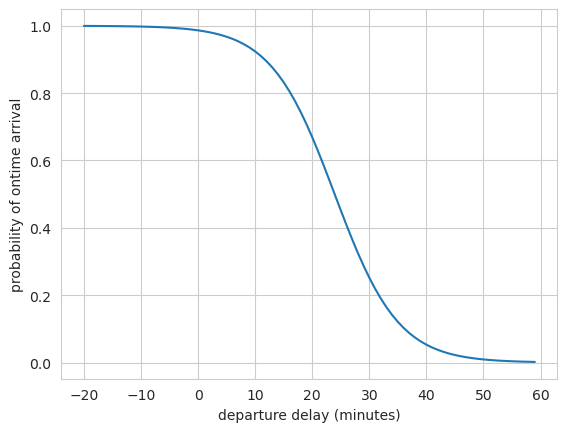

In [34]:
delay = np.arange(-20, 60, 1)
prob = [lrmodel.predict([d, 10, 500]) for d in delay]
ax = plt.plot(delay, prob)
plt.xlabel('departure delay (minutes)')
plt.ylabel('probability of ontime arrival')

In [35]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00001-*'.format(BUCKET)
flights = spark.read.json(inputs)
flights.createOrReplaceTempView('flights')

testquery = trainquery.replace("t.is_train_day == 'True'","t.is_train_day == 'False'")

In [36]:
## Mapping
testdata = spark.sql(testquery)
examples = testdata.rdd.map(to_example)

In [38]:
testdata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|             82184|             82184|             82184|            82184|
|   mean| 8.674377007690062|15.676676725396671|3.8409179402316753|838.9512557188747|
| stddev|38.764341740364586| 8.505730543334973| 41.25995960185183|600.3088554927516|
|    min|             -35.0|               1.0|             -70.0|          1005.00|
|    max|            1576.0|             154.0|            1557.0|           998.00|
+-------+------------------+------------------+------------------+-----------------+



In [39]:
def eval(labelpred):
    ''' 
        data = (label, pred)
            data[0] = label
            data[1] = pred
    '''
    cancel = labelpred.filter(lambda data: data[1] < 0.7)
    nocancel = labelpred.filter(lambda data: data[1] >= 0.7)
    corr_cancel = cancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()
    corr_nocancel = nocancel.filter(lambda data: data[0] == int(data[1] >= 0.7)).count()
    
    cancel_denom = cancel.count()
    nocancel_denom = nocancel.count()
    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel_denom, \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel_denom \
           }

In [40]:
lrmodel.clearThreshold() # so it returns probabilities
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))
print('All flights:')
print(eval(labelpred))

All flights:


{'total_cancel': 14689, 'correct_cancel': 0.8239498944788617, 'total_noncancel': 67495, 'correct_noncancel': 0.9556411586043411}


In [41]:
print('Flights near decision threshold:')
labelpred = labelpred.filter(lambda data: data[1] > 0.65 and data[1] < 0.75)
print(eval(labelpred))

Flights near decision threshold:


{'total_cancel': 714, 'correct_cancel': 0.3711484593837535, 'total_noncancel': 850, 'correct_noncancel': 0.6788235294117647}
